In [1]:
import scanpy as sc
from sctools import annotate


adata = sc.read_h5ad(
    '../data/tregs.tissue.scps.integrated.milo.h5ad'
)
annotate.assign_to_overrepresented_nhoods(adata, 0.1)
adata

Global seed set to 0


AnnData object with n_obs × n_vars = 9773 × 20912
    obs: 'sample_id', 'patient_id', 'status', 'tissue', 'cell_fraction', 'doublet', 'doublet_score', 'nFeature_RNA', 'nCount_RNA', 'percent_mt', 'percent_ribo', 'qc_pass', '_scvi_batch', '_scvi_labels', 'leiden_scvi_0.1', 'coarse_cell_types', 'leiden_scvi_0.4', 'dataset', 'sat1_status', 'clustering', 'sat1_status_majority_vote', 'condition', 'nhood_ixs_random', 'nhood_ixs_refined', 'nhood_kth_distance', 'nhood_annotation'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'leiden', 'log1p', 'neighbors', 'nhood_adata', 'umap'
    obsm: 'X_scvi', 'X_umap', 'nhoods'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [2]:
adata.X = adata.layers['counts'].copy()
adata.layers['cpm'] = sc.pp.normalize_total(
    adata,
    target_sum = 1e4,
    inplace = False
)['X']
adata.layers['logcpm'] = sc.pp.log1p(
    adata.layers['cpm'],
    copy = True
)
sc.tl.rank_genes_groups(
    adata, 
    'nhood_annotation', 
    groups = ['overrepresented'],
    use_raw = False,
    layer = 'logcpm',
    method = 'wilcoxon'
)

In [3]:
import pandas as pd
import numpy as np


def fetch_values(rect_array, idx):
    values = [
        val[0] for val in rect_array
    ]
    return values


rank_group_genes_dict = adata.uns['rank_genes_groups']
keys_to_fetch = ['names', 'scores', 'pvals', 'pvals_adj', 'logfoldchanges']
rank_data = {
    key: fetch_values(rank_group_genes_dict[key], 0)
    for key
    in keys_to_fetch
}
rank_data = pd.DataFrame.from_dict(rank_data)
rank_data['rank'] = np.arange(len(rank_data)) + 1
rank_data

,names,scores,pvals,pvals_adj,logfoldchanges,rank
0,SLC2A3,9.818805,9.344480e-23,9.770588e-19,1.563962,1
1,DDIT4,9.092203,9.705174e-20,6.765153e-16,1.379854,2
2,UBC,8.771951,1.755967e-18,7.344158e-15,0.787955,3
3,SAT1,8.682303,3.878346e-18,1.351733e-14,1.135213,4
4,TNFRSF4,8.277772,1.255017e-16,3.749273e-13,1.430683,5
...,...,...,...,...,...,...
20907,FYB1,-7.409895,1.263992e-13,1.888042e-10,-1.128060,20908
20908,LCK,-7.576435,3.551792e-14,6.189589e-11,-1.084241,20909
20909,FXYD5,-7.679052,1.602703e-14,3.046885e-11,-0.852216,20910
20910,B2M,-8.795399,1.425411e-18,7.344158e-15,-0.380531,20911


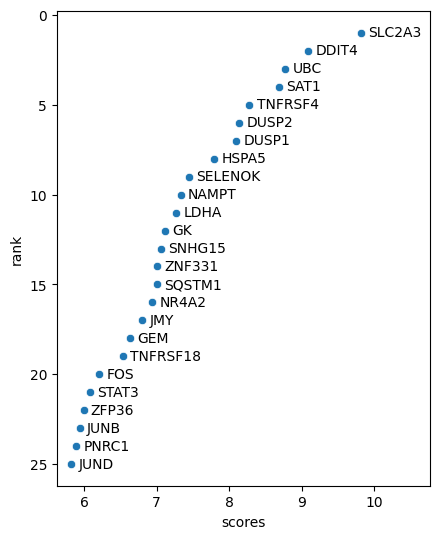

In [22]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['pdf.fonttype'] = 42


fig, ax = plt.subplots()
data = rank_data.nlargest(
    columns = ['scores'],
    n = 25
)
sns.scatterplot(
    data = data,
    x = 'scores',
    y = 'rank',
    ax = ax
)

for _, row in data.iterrows():
    name = row.names
    score = row.scores
    rank = row['rank']
    ax.text(
        score + 0.1,
        rank,
        name,
        va = 'center',
        ha = 'left'
    )
    
xmin, xmax = ax.get_xlim()
ax.set_xlim(xmin, xmax + 0.75)
ax.set_ylim(ax.get_ylim()[::-1])
fig.set_figwidth(4.5)
fig.set_figheight(5.5)
fig.tight_layout()
fig.savefig('../plots/tregs.tissue.scps.gene_ranks_of_overrepresented_nhoods.pdf')